In [19]:
config = {
    "path": {
        "dataset_path":"C:\\Users\\Cheon\\Dev\\deepcheese\\lob_data",
        "model_path":"C:\\Users\\Cheon\\Dev\\deepcheese\\models"
    },

    "dataset": {
        "ticker": "KQ150",
        "open": "090000",
        "close": "154500",
        "orderbook_level": 5,
        "time_window": 50,
        "price_window" : 10,
        "max_amount": 5,
        "train_ratio": 0.5,
        "val_ratio": 0.2,
        "test_ratio": 0.3,
        "predict_horizon": 100,
        "threshold": 0.0002
    }
}

In [20]:
import os
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt


_config_path = config["path"]
_config_dataset = config["dataset"]


def time_to_idx(timestring):
    hour = int(timestring[:2])
    minute = int(timestring[2:4])
    second = int(timestring[4:])
    return (hour - 9) * 60 * 60 + minute * 60 + second


def idx_to_time(idx):
    second = idx % 60
    minute = int((idx - second) / 60) % 60
    hour = (idx - second - minute * 60) // (60 * 60)
    return '%02d:%02d:%02d' % (hour + 9, minute, second)


def get_file_path(data_type, ticker, date="*"):
    match data_type:
        case "tradeprint":
            filename1 = "H0IFCNT0"
        case "orderbook":
            filename1 = "H0IFASP0"

    match ticker:
        case "KS200":
            filename2 = "101T*"
        case "KQ150":
            filename2 = "106T*"

    if date == "*":
        return os.path.join(_config_path["dataset_path"], f"{filename1}_{filename2}_{date}.csv")
    else:
        return glob.glob(os.path.join(_config_path["dataset_path"], f"{filename1}_{filename2}_{date}.csv"))[0]


def get_file_list(data_type, ticker):
    return glob.glob(get_file_path(data_type, ticker))


def get_days_list(ticker):
    def extract_days(file_list):
        day_list = []
        for filename in file_list:
            day_list.append(filename.split('.')[0].split('_')[-1])
        return day_list

    # return days which has coupled tradeprint and orderbook data
    day_list_1 = extract_days(get_file_list("tradeprint", ticker))
    day_list_2 = extract_days(get_file_list("orderbook", ticker))
    intersect_day = list(set(day_list_1) & set(day_list_2))
    intersect_day.sort()
    return intersect_day


def load_orderbook_data(filename):
    mul_fac = 10
    orderbook_level = 5

    time_data = []
    orderbook_data = []

    with open(filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for idx, row in enumerate(reader):
            temp_timestamp = row[1]
            update = len(time_data) == 0 or temp_timestamp != time_data[-1]
            if (not row[2] == '0.00') and update:
                # Process orderbook data in single timestamp
                temp_orderbook_data = []
                for i in range(1, orderbook_level + 1):
                    single_level = [
                        ###################################################
                        int(float(row[1+i])*mul_fac), # price  | ask side
                        int(row[21+i]),               # volume |
                        ###################################################
                        int(float(row[6+i])*mul_fac), # price  | bid side
                        int(row[26+i])                # volume |
                        ###################################################
                    ]
                    temp_orderbook_data.append(single_level)
                time_data.append(temp_timestamp)
                orderbook_data.append(temp_orderbook_data)
    return time_data, np.array(orderbook_data)


In [21]:
import torch
import numpy as np


class MovingWindow:
    def __init__(self, day):
        self.day = day
        self.ticker = _config_dataset["ticker"]
        self.level = _config_dataset["orderbook_level"]
        self.T = _config_dataset["time_window"]
        self.W = _config_dataset["price_window"]
        self.max_quantity = _config_dataset["max_amount"]
        self.predict_horizon = _config_dataset["predict_horizon"]
        self.threshold = _config_dataset["threshold"]


        file_path = get_file_path("orderbook", self.ticker, day)
        self.orderbook_time, self.orderbook_data = load_orderbook_data(file_path)
        self.movingwindow = []
        self.ticks = []

        self.start_idx = max(self.T - 1, self.predict_horizon)
        self.end_idx = len(self.orderbook_data) - self.predict_horizon - 1

        self.midprice = []
        self.ask1 = []
        self.bid1 = []
        self.midprice_idx = []
        self.__fill_movingwindow__(self.orderbook_data)

        self.label = []
        self.__fill_label__()

    def __len__(self):
        return self.end_idx - self.start_idx + 1
    
    def __moving_window_shot__(self, lob, ticks, data_min, data_max):
        lob_shot = lob.copy()
        lob_shot[:, 1:4:2] = np.minimum(lob_shot[:, 1:4:2], self.max_quantity)
        lob_shot[:,3] = -lob_shot[:,3]

        for i in range(1, lob_shot.shape[0]):
            lob_shot[i, 1:4:2] = lob_shot[i-1, 1:4:2] + lob_shot[i, 1:4:2]

        ask_side = lob_shot[:, 0:2]
        bid_side = lob_shot[::-1, 2:4]

        midprice = (ask_side[0, 0] + bid_side[0, 0]) / 2
        ask1 = ask_side[0, 0]
        bid1 = bid_side[0, 0]
        midprice_idx = round(midprice - (data_min - self.W))

        moving_window_shot = np.zeros(ticks.shape)

        # bid side
        for i in range(5):
            if i == 0:
                start_idx = 0
            else:
                start_idx = bid_side[i-1, 0] - (data_min - self.W) + 1
            end_idx = bid_side[i, 0] - (data_min - self.W)
            moving_window_shot[start_idx:end_idx+1] = bid_side[i, 1]

        # ask side
        for i in range(5):
            if i == 4:
                end_idx = len(moving_window_shot)
            else:
                end_idx = ask_side[i + 1, 0] - (data_min - self.W) + 1
            start_idx = ask_side[i, 0] - (data_min - self.W)
            moving_window_shot[start_idx:end_idx+1] = ask_side[i, 1]

        return moving_window_shot, midprice, ask1, bid1, midprice_idx


    def __fill_movingwindow__(self, data):
        processed_data = []
        midprice = []
        ask1 = []
        bid1 = []
        midprice_idx = []

        data_min = np.min(data[:,:,0:3:2].flatten())
        data_max = np.max(data[:,:,0:3:2].flatten())
        ticks = np.arange(data_min - self.W, data_max + self.W + 1, 1)

        for i in range(data.shape[0]):
            lob_shot, midprice_, ask_1, bid_1, midprice_idx_ = self.__moving_window_shot__(data[i], ticks, data_min, data_max)
            processed_data.append(lob_shot)
            midprice.append(midprice_)
            ask1.append(ask_1)
            bid1.append(bid_1)
            midprice_idx.append(midprice_idx_)

        self.movingwindow = np.array(processed_data) / (self.max_quantity * 5)
        self.ticks = ticks
        self.midprice = np.array(midprice)
        self.ask1 = np.array(ask1)
        self.bid1 = np.array(bid1)
        self.midprice_idx = np.array(midprice_idx)
        

    def __fill_label__(self):
        label = np.zeros(self.end_idx - self.start_idx + 1)

        for index in range(self.end_idx - self.start_idx + 1):
            index_re = index + self.start_idx
            m_prev = np.mean(self.midprice[index_re - self.predict_horizon:index_re])
            m_next = np.mean(self.midprice[index_re + 1:index_re + self.predict_horizon + 1])
            l = (m_next - m_prev) / m_prev

            if l > self.threshold:
                tmp_label = 2
            elif l < -self.threshold:
                tmp_label = 0
            else:
                tmp_label = 1
            label[index] = tmp_label
        self.label = label


    def __getitem__(self, index):
        index_re = index + self.start_idx
        shot = self.movingwindow[index_re-self.T+1:index_re+1,
                                 self.midprice_idx[index_re]-self.W:self.midprice_idx[index_re]+self.W].T
        return np.expand_dims(shot, axis=0), self.label[index]
    
    
    def get_price(self):
        return self.midprice[self.start_idx:self.end_idx + 1], \
               self.ask1[self.start_idx:self.end_idx + 1], \
               self.bid1[self.start_idx:self.end_idx + 1]


In [22]:
from ray.util.multiprocessing import Pool
import gymnasium as gym
from gymnasium import spaces

class MarketEnv(gym.Env):
    def __init__(self, days) -> None:
        self.days = days
        with Pool() as pool:
            self.day_datasets = pool.map(MovingWindow, self.days)
        
        self.observation_space = spaces.Box(low=-1, high=1,
                                            shape=(1, 20, 50),
                                            dtype=np.float64)
        self.action_space = spaces.Discrete(3)

        self.reset()

    def reset(self, seed=None):
        self.day_idx = np.random.randint(len(self.days))
        self.day = self.days[self.day_idx]
        self.day_dataset = self.day_datasets[self.day_idx]
        self.day_len = len(self.day_dataset)
        self.max_position = 1
        self.fee = 0.003 / 100

        self.t = 0
        self.t_max = self.day_len - 1

        self.midprice, self.ask1, self.bid1 = self.day_dataset.get_price()
        self.cumulative_reward = np.zeros(self.day_len)
        self.position = np.zeros(self.day_len)
        self.cash = np.zeros(self.day_len)
        self.balance = np.zeros(self.day_len)
        
        self.long_inventory = []
        self.short_inventory = []

        return self.day_dataset[self.t][0], {}#, np.array([0.0])

    def step(self, action):
        self.t += 1
        
        # action: 0 - hold, 1 - buy, 2 - sell
        if action == 1 and self.position[self.t - 1] < self.max_position:
            position_change = 1
        elif action == 2 and self.position[self.t - 1] > -self.max_position:
            position_change = -1
        else:
            position_change = 0
        
        # trading price
        if position_change == 1:
            trade_price = self.ask1[self.t]
        elif position_change == -1:
            trade_price = self.bid1[self.t]
        else:
            trade_price = self.midprice[self.t]
        
        self.position[self.t] = self.position[self.t - 1] + position_change
        self.cash[self.t] = self.cash[self.t - 1] - trade_price * position_change - abs(position_change) * self.fee * trade_price
        self.balance[self.t] = self.cash[self.t] + self.position[self.t] * self.midprice[self.t]

        reward = self.balance[self.t] - self.balance[self.t - 1]
            
        self.cumulative_reward[self.t] = self.cumulative_reward[self.t - 1] + reward
        done = self.t == self.t_max

        if done:
            state = None
            info = {
                "position": self.position,
                "balance": self.balance,
                "cumulative_reward": self.cumulative_reward,
                "midprice": self.midprice
            }
        else:
            state = self.day_dataset[self.t][0]
            info = {
                "position": self.position[self.t],
                "balance": self.balance[self.t],
                "cumulative_reward": self.cumulative_reward[self.t],
                "midprice": self.midprice[self.t]
            }
        
        state_pos = np.array([self.position[self.t]/self.max_position])
        truncated = False
        return state, reward, done, truncated, info
    
    def evaluate_balance(self):
        self.position_history[self.t] = self.position
        self.balance_history[self.t] = self.balance
        self.cumulative_reward_history[self.t] = self.cumulative_reward
        return self.balance_history[-1]
    
    def close(self):
        pass
        

In [23]:
days = get_days_list(_config_dataset["ticker"])

val_length = max(round(len(days) * _config_dataset["val_ratio"]), 1)
test_length = max(round(len(days) * _config_dataset["test_ratio"]), 1)
train_length = len(days) - (val_length + test_length)

train_days = days[:train_length]
val_days = days[train_length:train_length + val_length]
test_days = days[train_length + val_length:]

print(f"% {len(train_days)} days for train ({train_days[0]} ~ {train_days[-1]})")
print(f"% {len(val_days)} days for validation ({val_days[0]} ~ {val_days[-1]})")
print(f"% {len(test_days)} days for test ({test_days[0]} ~ {test_days[-1]})")

% 38 days for train (2023-04-03 ~ 2023-05-26)
% 15 days for validation (2023-05-30 ~ 2023-06-21)
% 23 days for test (2023-06-22 ~ 2023-07-24)


In [24]:
from stable_baselines3.common.env_checker import check_env

train_env = MarketEnv(train_days)
val_env = MarketEnv(val_days)
test_env = MarketEnv(test_days)

check_env(train_env)

C:\Users\Cheon\Dev\deepcheese\.venv\Lib\site-packages\stable_baselines3\common\env_checker.py:30: UserWarning: It seems that your observation  is an image but its `dtype` is (float64) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
C:\Users\Cheon\Dev\deepcheese\.venv\Lib\site-packages\stable_baselines3\common\env_checker.py:38: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn(
C:\Users\Cheon\Dev\deepcheese\.venv\Lib\site-packages\stable_baselines3\common\env_checker.py:51: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom features extractor cf. https://stable-baselines3.readthedocs.io/en/master/guide/custom_pol

In [25]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

eval_callback = EvalCallback(val_env, best_model_save_path=_config_path["model_path"],
                                log_path=_config_path["model_path"], eval_freq=100000,
                                deterministic=True, render=True, n_eval_episodes=5)

rl_model = PPO("CnnPolicy", train_env, verbose=False)

AssertionError: You should use NatureCNN only with images not with Box(-1.0, 1.0, (1, 20, 50), float64)
(you are probably using `CnnPolicy` instead of `MlpPolicy` or `MultiInputPolicy`)
If you are using a custom environment,
please check it using our env checker:
https://stable-baselines3.readthedocs.io/en/master/common/env_checker.html.
If you are using `VecNormalize` or already normalized channel-first images you should pass `normalize_images=False`: 
https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html

In [26]:
rl_model.learn(total_timesteps=10000000, callback=eval_callback)

Eval num_timesteps=100000, episode_reward=-75.10 +/- 278.18
Episode length: 22584.20 +/- 361.81
New best mean reward!
Eval num_timesteps=200000, episode_reward=-45.67 +/- 291.77
Episode length: 22117.00 +/- 781.63
New best mean reward!
Eval num_timesteps=300000, episode_reward=-116.30 +/- 285.58
Episode length: 22349.00 +/- 447.59
Eval num_timesteps=400000, episode_reward=95.70 +/- 77.77
Episode length: 21640.20 +/- 571.87
New best mean reward!
Eval num_timesteps=500000, episode_reward=-213.91 +/- 330.37
Episode length: 22434.60 +/- 771.09
Eval num_timesteps=600000, episode_reward=125.30 +/- 59.02
Episode length: 21732.00 +/- 530.92
New best mean reward!
Eval num_timesteps=700000, episode_reward=-4.30 +/- 147.01
Episode length: 21262.20 +/- 1408.51
Eval num_timesteps=800000, episode_reward=-95.30 +/- 82.80
Episode length: 21432.80 +/- 385.60
Eval num_timesteps=900000, episode_reward=-118.10 +/- 290.39
Episode length: 22519.60 +/- 379.19
Eval num_timesteps=1000000, episode_reward=-45.01

In [17]:
# test episode
obs, info = test_env.reset()
balance_hist = []
bench_hist = []
position_hist = []

done = False
while not done:
    #test_env.render()

    action, _ = rl_model.predict(obs)
    obs, reward, done, trunc, info = test_env.step(action)

    balance_hist.append(info['balance'])
    bench_hist.append(info['midprice'])
    position_hist.append(info['position'])

test_env.close()

ValueError: Input could not be cast to an at-least-1D NumPy array

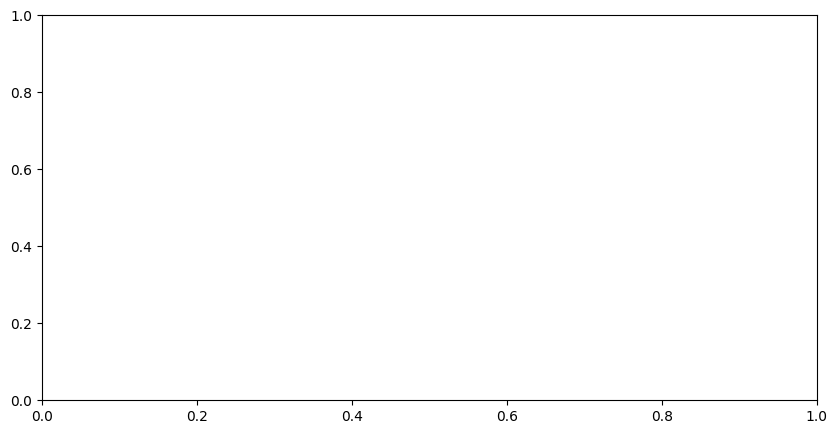

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(balance_hist)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(bench_hist)
y = position_hist

for i in range(len(y)):
    if y[i] == 0:
        pass
    else:
        if y[i] == 1:
            color = 'red'
        elif y[i] == -1:
            color = 'blue'
        plt.axvspan(i - 0.5, i + 0.5, color=color)

plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y)
plt.show()